In [1]:
from syotools.models import Telescope, Camera, PhotometricExposure
from syotools.utils.jsonunit import str_jsunit
from syotools.spectra import SpectralLibrary
import astropy.units as u
import numpy as np 
import matplotlib.pyplot as plt
from strong_lens import StrongLens
import pandas as pd
from tqdm import tqdm
import pickle
import os

Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/data/bwedig/.conda/envs/hwo/lib/python3.10/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.


In [2]:
figure_dir = 'figures'
output_dir = 'output'

In [3]:
snr_detectable = 10
snr_characterizable = 25
snr_band = 'J'

In [9]:
apertures = np.linspace(4, 10, 7)
# apertures = [6]

In [ ]:
df = pd.read_csv('hwo_lens_population.csv')
strong_lenses = [StrongLens(row) for _, row in df.iterrows()]

In [ ]:
snr_dict = {}
detectable_dict = {}
characterizable_dict = {}

for aperture in tqdm(apertures, desc='Apertures', position=0, leave=True):
    snr_list = []
    detectable_list = []
    characterizable_list = []

    t, c = Telescope(), Camera()
    t.set_from_json('EAC1', False)
    t.aperture = aperture * u.m
    t.add_camera(c)

    band_idx = c.bandnames.index(snr_band)

    for strong_lens in tqdm(strong_lenses, desc='Strong lenses', position=1, leave=False):
        e = c.create_exposure()
        e.sed_id = 'sbc'
        e.redshift = strong_lens.z_source

        band = 'v'
        lensed_source_mag = strong_lens.get_lensed_source_mag(band)
        e.renorm_sed(lensed_source_mag * u.ABmag, bandpass=band, force=False)

        sed, snrs = e.recover('sed', 'snr')
        snr = snrs.value[band_idx]
        snr_list.append(snr)

        if snr > snr_detectable:
            detectable_list.append(strong_lens)
        if snr > snr_characterizable:
            characterizable_list.append(strong_lens)
        
    snr_dict[aperture] = snr_list
    detectable_dict[aperture] = detectable_list
    characterizable_dict[aperture] = characterizable_list

with open(os.path.join(output_dir, 'aper_snr_dict.pkl'), 'wb') as results_file:
    pickle.dump(snr_dict, results_file)

with open(os.path.join(output_dir, 'aper_detectable_dict.pkl'), 'wb') as results_file:
    pickle.dump(detectable_dict, results_file)

with open(os.path.join(output_dir, 'aper_characterizable_dict.pkl'), 'wb') as results_file:
    pickle.dump(characterizable_dict, results_file)

In [4]:
with open(os.path.join(output_dir, 'aper_snr_dict.pkl'), 'rb') as results_file:
    snr_dict = pickle.load(results_file)

with open(os.path.join(output_dir, 'aper_detectable_dict.pkl'), 'rb') as results_file:
    detectable_dict = pickle.load(results_file)

with open(os.path.join(output_dir, 'aper_characterizable_dict.pkl'), 'rb') as results_file:
    characterizable_dict = pickle.load(results_file)

In [5]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# plt.style.use('science.mplstyle')

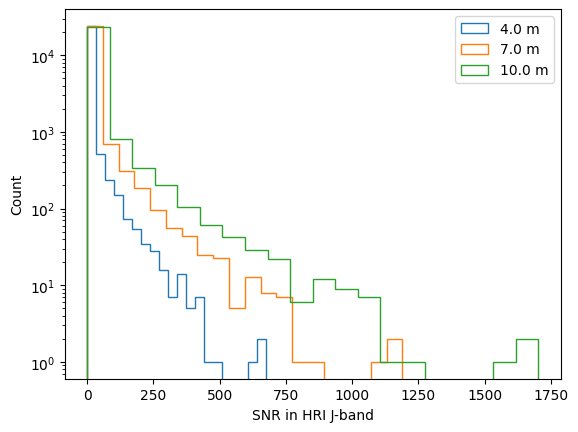

In [7]:
# bins = int(np.sqrt(len(strong_lenses)))

for aperture, snr_list in snr_dict.items():
    if aperture == 4 or aperture == 7 or aperture == 10:
        plt.hist(snr_list, bins=20, label=f'{aperture:.1f} m', histtype='step')

plt.xlabel('SNR in HRI J-band')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'aper_snr.png'))
plt.show()

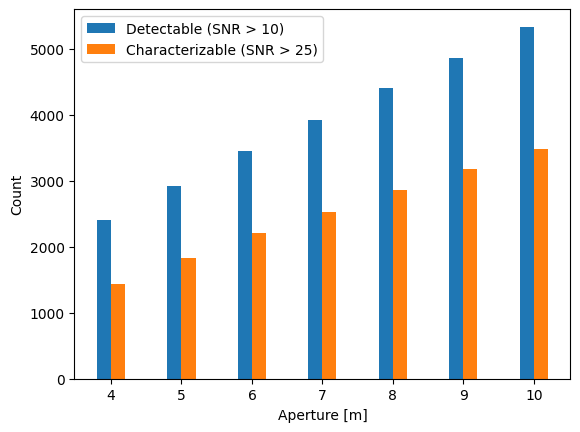

In [11]:
detectable, characterizable = [], []
for aperture in apertures:
    detectable.append(np.sum(np.array(snr_dict[aperture]) > snr_detectable))
    characterizable.append(np.sum(np.array(snr_dict[aperture]) > snr_characterizable))

offset = 0.1
plt.bar([a - offset for a in apertures], detectable, label=f'Detectable (SNR > {snr_detectable})', width=offset * 2)
plt.bar([a + offset for a in apertures], characterizable, label=f'Characterizable (SNR > {snr_characterizable})', width=offset * 2)
plt.xlabel('Aperture [m]')
plt.ylabel('Count')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'aper_count.png'))
plt.show()